In [2]:
import tensorflow as tf
import os
import sys
import random
import numpy as np
 
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib notebook
 
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
 
DATA_PATH = '/home/zzhang/nuclei/stage1_train/'

In [8]:
image_ids = next(os.walk(DATA_PATH))[1]

In [9]:
len(image_ids)

670

In [10]:
seed = 42
random.seed = seed
np.random.seed = seed

image_ids = next(os.walk(DATA_PATH))[1]

X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X

y_train=Y

100%|██████████| 670/670 [04:00<00:00,  7.30it/s]


In [15]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
checkpoint_path = "/home/zzhang/nuclei/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]

results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)

Train on 603 samples, validate on 67 samples


W0811 14:14:42.976720 139987484280640 deprecation.py:323] From /home/zzhang/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
592/603 [============================>.] - ETA: 0s - loss: 0.3559 - acc: 0.8461
Epoch 00001: saving model to /home/zzhang/nuclei/training_1/cp.ckpt
603/603 [==============================] - 48s 79ms/sample - loss: 0.3526 - acc: 0.8476 - val_loss: 0.1906 - val_acc: 0.9211
Epoch 2/20
592/603 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9316
Epoch 00002: saving model to /home/zzhang/nuclei/training_1/cp.ckpt
603/603 [==============================] - 45s 74ms/sample - loss: 0.1743 - acc: 0.9314 - val_loss: 0.1825 - val_acc: 0.9323
Epoch 3/20
592/603 [============================>.] - ETA: 0s - loss: 0.1458 - acc: 0.9432
Epoch 00003: saving model to /home/zzhang/nuclei/training_1/cp.ckpt
603/603 [==============================] - 49s 80ms/sample - loss: 0.1454 - acc: 0.9433 - val_loss: 0.1390 - val_acc: 0.9449
Epoch 4/20
592/603 [============================>.] - ETA: 0s - loss: 0.1285 - acc: 0.9509
Epoch 00004: saving model to /home/zzhang/nuclei/training

In [36]:
idx = random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
predict = np.squeeze((predict > 0.5).astype(np.uint8))

predict

1/1 [==============================] - 0s 24ms/sample


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<IPython.core.display.Javascript object>


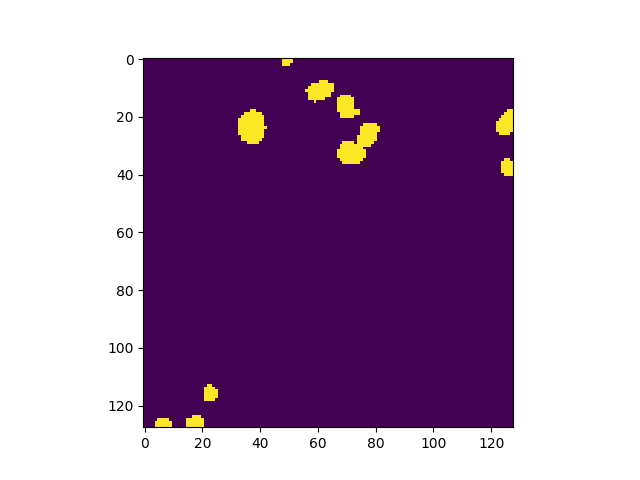

<IPython.core.display.Javascript object>


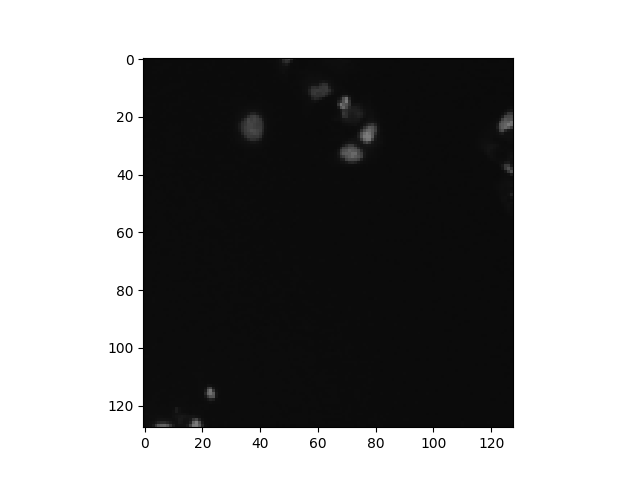

In [37]:
f1 = plt.figure(1)

plt.imshow(predict)
plt.show()

f2 = plt.figure(2)
plt.imshow(x_train[idx])

plt.show()

In [24]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [22]:
y_pred = model.predict(X)

In [27]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

In [38]:
y_pred_ = y_pred > 0.5
get_iou_vector(y_pred_, Y)

0.6595522388059705

In [43]:
# Save entire model to a HDF5 file
model.save('nuclei-u-net_model.h5')

In [6]:
model = tf.keras.models.load_model('nuclei-u-net_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [61]:
TEST_PATH = '/home/zzhang/nuclei/stage2_test_final/'
test_ids = next(os.walk(TEST_PATH))[1]

In [93]:
from skimage.color import gray2rgb
from tqdm import tqdm_notebook

In [95]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    if len(img.shape) == 2:
        img = gray2rgb(img)
    img = img[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


In [96]:
preds_test = model.predict(X_test, verbose=1)

3019/3019 [==============================] - 48s 16ms/sample


In [97]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)



In [98]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [99]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [101]:
import pandas as pd
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)

In [100]:
len(new_test_ids)

56093

In [82]:
img_path = "/home/zzhang/nuclei/stage2_test_final/646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0/images/646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0.png"
#img_path="/home/zzhang/nuclei/stage2_test_final/645b599a8933519a22037a231a0a11ce013d9a53c1d23b722549ceec2120800b/images/645b599a8933519a22037a231a0a11ce013d9a53c1d23b722549ceec2120800b.png"

In [83]:
img = imread(img_path)

In [88]:
len(img.shape)

2

In [86]:
img.shape

(128, 128)

/home/zzhang/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


<IPython.core.display.Javascript object>


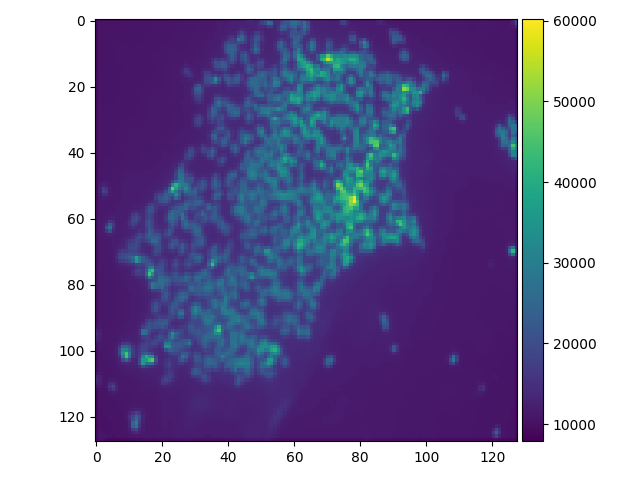

In [87]:
imshow(img)

In [89]:
resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

array([[ 7989.46875,  9204.75   ,  9232.5    , ...,  9827.5625 ,
        12901.46875, 20500.5    ],
       [ 9150.3125 , 10549.21875, 10560.09375, ..., 11231.96875,
        12803.4375 , 20091.5    ],
       [ 9112.28125, 10566.03125, 10551.96875, ..., 11170.3125 ,
        11565.125  , 13624.15625],
       ...,
       [ 9197.1875 , 10623.34375, 10569.15625, ..., 10497.0625 ,
        10482.90625,  9034.75   ],
       [ 9429.375  , 11084.59375, 10938.0625 , ..., 10513.5625 ,
        10460.     ,  9009.9375 ],
       [ 8943.46875, 10830.     , 10306.1875 , ...,  9169.1875 ,
         9107.5625 ,  7859.59375]])